C:\Users\jesus\AppData\Local\Temp\ipykernel_35992\2367941821.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(session_step_times)


=== Time to Complete (TTC) por paso ===
variation     Control      Test
TTC_step_1   0.991939  0.776086
TTC_step_2   0.809743  1.285095
TTC_step_3   1.868250  1.854866
TTC_confirm  2.818672  2.388880

=== T-test para Time to Complete (TTC) por paso ===

step_1: t-stat = -5.7868, p-value (one-tailed) = 0.000000
   -> Diferencia significativa (rechazamos H0).

step_2: t-stat = 13.6186, p-value (one-tailed) = 1.000000
   -> No hay diferencia significativa (no rechazamos H0).

step_3: t-stat = -0.3243, p-value (one-tailed) = 0.372863
   -> No hay diferencia significativa (no rechazamos H0).

confirm: t-stat = -6.4856, p-value (one-tailed) = 0.000000
   -> Diferencia significativa (rechazamos H0).



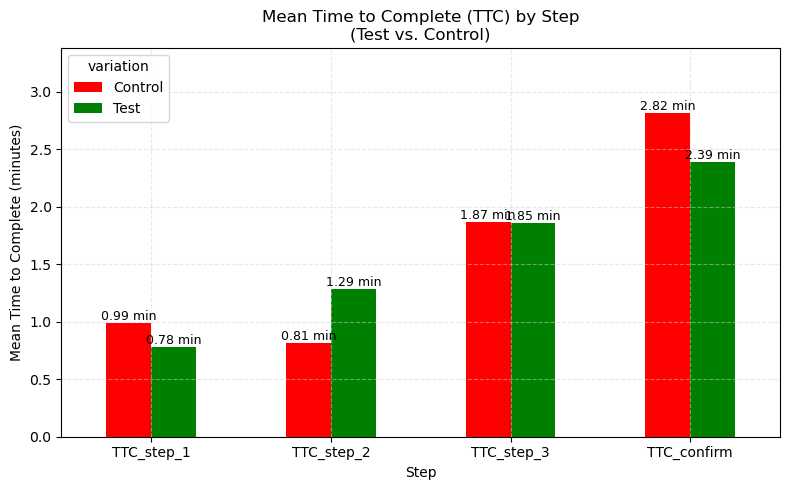

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# --------------------------------------------------
# PASO 1: Cargar el DataFrame y convertir 'date_time' a datetime
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")
df["date_time"] = pd.to_datetime(df["date_time"])

# --------------------------------------------------
# PASO 2: Filtrar registros relevantes (todos los pasos)
# --------------------------------------------------
steps = ["start", "step_1", "step_2", "step_3", "confirm"]
df_steps = df[df["process_step"].isin(steps)].copy()

# --------------------------------------------------
# PASO 3: Calcular el tiempo en cada paso por sesión
# --------------------------------------------------
def session_step_times(group):
    step_times = {}
    for step in steps:
        step_time = group.loc[group["process_step"] == step, "date_time"].min()
        step_times[step] = step_time
    return pd.Series(step_times)

df_session_steps = (
    df_steps.groupby(["visit_id", "variation"], as_index=False)
            .apply(session_step_times)
).reset_index(drop=True)

# Eliminar sesiones sin 'confirm' (porque no finalizaron el flujo)
df_session_steps = df_session_steps.dropna(subset=["confirm"])

# --------------------------------------------------
# PASO 4: Calcular el tiempo de permanencia en cada paso
# --------------------------------------------------
for i in range(len(steps) - 1):
    step_col = f"TTC_{steps[i+1]}"
    df_session_steps[step_col] = (
        df_session_steps[steps[i+1]] - df_session_steps[steps[i]]
    ).dt.total_seconds() / 60  # Convertir a minutos

# Filtrar solo las columnas numéricas para evitar errores con .mean()
numeric_cols = ["variation"] + [f"TTC_{step}" for step in steps[1:]]
df_ttc = df_session_steps[numeric_cols].copy()

# Asegurarse de que todas las columnas TTC sean numéricas
for col in df_ttc.columns[1:]:  # Excluimos 'variation'
    df_ttc[col] = pd.to_numeric(df_ttc[col], errors='coerce')

# Eliminar filas con valores NaN o negativos en TTC
df_ttc = df_ttc.dropna(subset=[f"TTC_{step}" for step in steps[1:]])
df_ttc = df_ttc[df_ttc.iloc[:, 1:].ge(0).all(axis=1)]  # Solo mantener valores >= 0

# --------------------------------------------------
# PASO 5: Calcular la media del TTC por paso y grupo
# --------------------------------------------------
df_ttc_means = df_ttc.groupby("variation").mean().T

print("=== Time to Complete (TTC) por paso ===")
print(df_ttc_means)

# --------------------------------------------------
# PASO 6: Test de Hipótesis por paso
# --------------------------------------------------
alpha = 0.05
print("\n=== T-test para Time to Complete (TTC) por paso ===\n")

for step in steps[1:]:  # Ignoramos "start" porque no hay TTC antes de él
    ttc_test = df_ttc[df_ttc["variation"] == "Test"][f"TTC_{step}"].dropna()
    ttc_control = df_ttc[df_ttc["variation"] == "Control"][f"TTC_{step}"].dropna()

    if len(ttc_test) == 0 or len(ttc_control) == 0:
        print(f"{step}: Datos insuficientes en Test o Control.")
        continue

    t_stat, p_two = stats.ttest_ind(ttc_test, ttc_control, equal_var=False)
    p_one = p_two / 2 if t_stat < 0 else 1 - p_two / 2

    print(f"{step}: t-stat = {t_stat:.4f}, p-value (one-tailed) = {p_one:.6f}")
    if p_one < alpha:
        print("   -> Diferencia significativa (rechazamos H0).")
    else:
        print("   -> No hay diferencia significativa (no rechazamos H0).")
    print()

# --------------------------------------------------
# PASO 7: Graficar la media de TTC por paso y grupo
# --------------------------------------------------
color_map = {"Control": "red", "Test": "green"}
colors = [color_map.get(col, "gray") for col in df_ttc_means.columns]

fig, ax = plt.subplots(figsize=(8, 5))
df_ttc_means.plot(kind="bar", ax=ax, color=colors, legend=True)

ax.set_title("Mean Time to Complete (TTC) by Step\n(Test vs. Control)")
ax.set_xlabel("Step")
ax.set_ylabel("Mean Time to Complete (minutes)")
ax.set_ylim(0, df_ttc_means.max().max() * 1.2)

# Añadir rejilla con líneas discontinuas grises
ax.grid(True, which="major", axis="both", color="lightgray", linestyle="--", alpha=0.5)

# Añadir etiquetas con valores sobre cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.2f} min",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/ttc_by_step.jpg", dpi=300, bbox_inches='tight')
plt.show()
